In [1]:
import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import datetime
import pandas as pd
from analisis.general.io_helper import getMkdir

OBSV_DATE = datetime.date(year=2022, month=10, day=21).strftime("%Y-%m-%d")

OBJ_DATA_DIR = "/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464"

DATE_DATA_DIR = [os.path.join(OBJ_DATA_DIR, d) for d in os.listdir(OBJ_DATA_DIR) if OBSV_DATE in d and os.path.isdir(os.path.join(OBJ_DATA_DIR, d))][0]
EPOCH_OBSV_KEY = "E_OTIME"

# TODO on run: update this whenever reference star targets change
STAR_IDS = {
	1: "ATO J339.9469+45.1464", # Object

	# Ref stars
	2: "TYC 3620-332-1",
	3: "TYC 3620-254-1"
}

assert os.path.exists(DATE_DATA_DIR), f"{DATE_DATA_DIR} not found"
DATE_DATA_DIR

'/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-10-21'

In [2]:
import numpy as np
from scipy import stats
from astropy.io import ascii

PHOTOMETRIC_BASE_KEYS = ["SUM", "AREA", "FLUX", "MAG", "MERR"]
OBSV_KEY = "OTIME"

qphotResultsDir = os.path.join(DATE_DATA_DIR, "corrected", "iraf-shifted", "qphot-results")
assert os.path.exists(qphotResultsDir), qphotResultsDir

data = ascii.read(os.path.join(qphotResultsDir, "phot"))
pandasData = data.to_pandas()
apertureCols = [c for c in pandasData.columns if c.startswith('RAPERT')]
pandasData[OBSV_KEY] = pd.to_datetime(pandasData[OBSV_KEY])

# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#from-timestamps-to-epoch
# pandasData[EPOCH_OBSV_KEY] = (pandasData[OBSV_KEY] - pd.Timestamp("1970-01-01")) / pd.Timedelta(hours=1.0)
pandasData[EPOCH_OBSV_KEY] = pd.DatetimeIndex(pandasData[OBSV_KEY]).to_julian_date()

for starId, starName in STAR_IDS.items():
	starData = pandasData[pandasData['LID'] == starId].copy()		
	starResultsDir = getMkdir(os.path.join(qphotResultsDir, starName))
	for rapert in apertureCols:
		apertureId = rapert.replace("RAPERT", "")
		apertureRadius = starData.loc[starData.index[0], f"RAPERT{apertureId}"]
		apertureDir = getMkdir(os.path.join(starResultsDir, f"{rapert} - {apertureRadius}"))
		for basePhotKey in PHOTOMETRIC_BASE_KEYS:
			photKey = f"{basePhotKey}{apertureId}"
			photDf = starData[[EPOCH_OBSV_KEY, photKey]].copy()
			photDf = photDf[~(np.isnan(photDf[photKey]))]
			
			photDf['zscore'] = np.abs(stats.zscore(photDf[photKey]))
			photDf = photDf[(np.abs(stats.zscore(photDf[photKey])) < 2)]

			photDf.to_csv(os.path.join(apertureDir, f"{basePhotKey}.dat"), index=False, sep=' ')

data

IMAGE,XINIT,YINIT,ID,COORDS,LID,XCENTER,YCENTER,XSHIFT,YSHIFT,XERR,YERR,CIER,CERROR,MSKY,STDEV,SSKEW,NSKY,NSREJ,SIER,SERROR,ITIME,XAIRMASS,IFILTER,OTIME,RAPERT1,SUM1,AREA1,FLUX1,MAG1,MERR1,PIER1,PERROR1,RAPERT2,SUM2,AREA2,FLUX2,MAG2,MERR2,PIER2,PERROR2,RAPERT3,SUM3,AREA3,FLUX3,MAG3,MERR3,PIER3,PERROR3,RAPERT4,SUM4,AREA4,FLUX4,MAG4,MERR4,PIER4,PERROR4,RAPERT5,SUM5,AREA5,FLUX5,MAG5,MERR5,PIER5,PERROR5,RAPERT6,SUM6,AREA6,FLUX6,MAG6,MERR6,PIER6,PERROR6,RAPERT7,SUM7,AREA7,FLUX7,MAG7,MERR7,PIER7,PERROR7,RAPERT8,SUM8,AREA8,FLUX8,MAG8,MERR8,PIER8,PERROR8,RAPERT9,SUM9,AREA9,FLUX9,MAG9,MERR9,PIER9,PERROR9
imagename,pixels,pixels,,filename,,pixels,pixels,pixels,pixels,pixels,pixels,,cerrors,counts,counts,counts,npix,npix,,serrors,timeunit,number,name,timeunit,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors
str23,float64,float64,int64,str6,int64,float64,float64,float64,float64,float64,float64,int64,str8,float64,float64,float64,int64,int64,int64,str7,float64,float64,str9,str23,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7
s_bdf_2022-10-21_22-54-,958.000,597.870,1,coords,1,958.751,598.943,0.751,1.073,0.009,0.009,107,BigShift,134.9789,25.70022,11.68588,2967,88,0,NoError,60,1.077095,Luminance,2022-10-21T22:54:21.841,6.00,45998.69,113.2929,30706.53,18.227,0.010,0,NoError,7.00,54216.29,154.27,33393.09,18.136,0.011,0,NoError,8.00,62453.74,201.3752,35272.34,18.077,0.012,0,NoError,9.00,70900.74,254.7587,36513.69,18.039,0.013,0,NoError,10.00,79804.84,314.2922,37382.02,18.014,0.014,0,NoError,20.00,208178.4,1256.977,38512.91,17.981,0.031,0,NoError,21.00,225449,1385.803,38394.77,17.985,0.033,0,NoError,22.00,243484.3,1520.767,38212.82,17.990,0.035,0,NoError,23.00,262370.9,1661.94,38044,17.995,0.037,0,NoError
s_bdf_2022-10-21_22-54-,1390.688,793.727,2,coords,2,1391.703,794.704,1.016,0.977,0.001,0.001,107,BigShift,154.5775,28.41208,10.45855,3051,12,0,NoError,60,1.077095,Luminance,2022-10-21T22:54:21.841,6.00,3799523,113.3338,3782004,13.001,0.000,0,NoError,7.00,4135188,154.1977,4111353,12.910,0.000,0,NoError,8.00,4353035,201.2175,4321931,12.856,0.000,0,NoError,9.00,4501306,254.8439,4461913,12.822,0.000,0,NoError,10.00,4607994,314.5208,4559376,12.798,0.000,0,NoError,20.00,5046249,1256.803,4851975,12.731,0.000,0,NoError,21.00,5073496,1385.723,4859294,12.729,0.000,0,NoError,22.00,5100332,1520.928,4865230,12.728,0.000,0,NoError,23.00,5127122,1662.181,4870187,12.727,0.000,0,NoError
s_bdf_2022-10-21_22-54-,608.770,1040.306,3,coords,3,609.676,1040.891,0.907,0.585,0.001,0.001,0,NoError,143.1318,27.05877,4.190095,3053,10,0,NoError,60,1.077095,Luminance,2022-10-21T22:54:21.841,6.00,2286174,113.442,2269937,13.555,0.000,0,NoError,7.00,2495671,154.0575,2473621,13.462,0.000,0,NoError,8.00,2633420,201.5378,2604573,13.406,0.000,0,NoError,9.00,2725307,254.5553,2688872,13.371,0.000,0,NoError,10.00,2794054,314.389,2749055,13.347,0.000,0,NoError,20.00,3110276,1257.179,2930334,13.278,0.000,0,NoError,21.00,3133483,1385.643,2935154,13.276,0.000,0,NoError,22.00,3156818,1520.636,2939167,13.275,0.001,0,NoError,23.00,3180604,1662.259,2942682,13.274,0.001,0,NoError
s_bdf_2022-10-21_22-55-,958.000,597.870,4,coords,1,958.878,599.123,0.878,1.253,0.009,0.009,107,BigShif

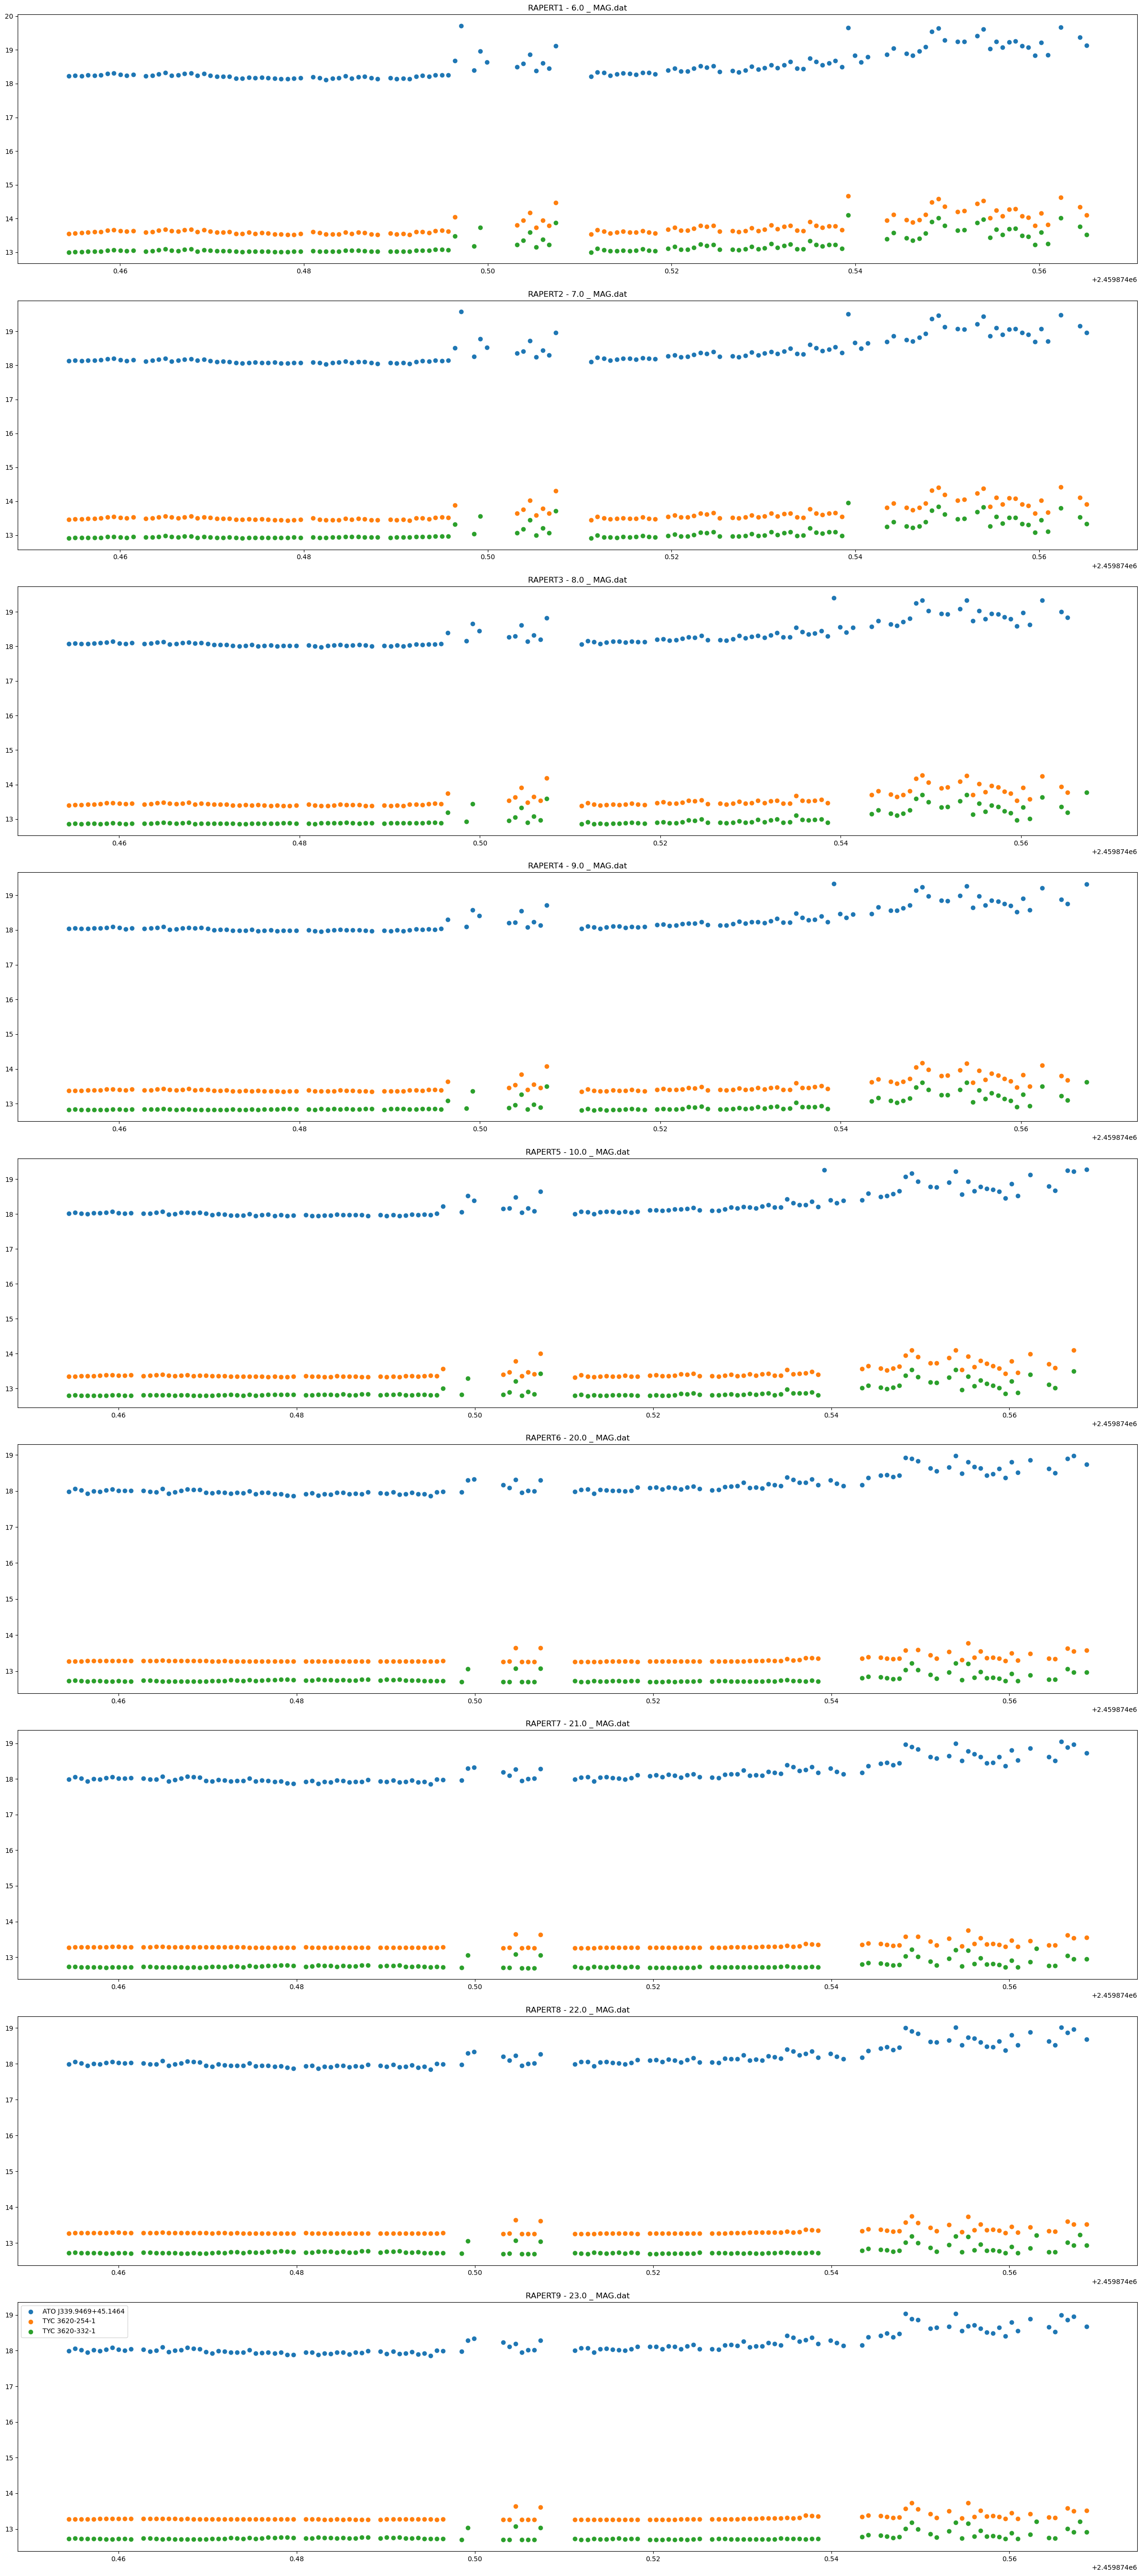

In [5]:
import matplotlib.pyplot as plt

OBJ_NAMES = ["ATO J339.9469+45.1464", "TYC 3620-254-1","TYC 3620-332-1"]
qphotResultsDir = os.path.join(DATE_DATA_DIR, "corrected", "iraf-shifted", "qphot-results")
numApertures = len(os.listdir(os.path.join(qphotResultsDir, OBJ_NAMES[0])))

def plotApertureMeasurements(subplots, quantity: str):
	for objName in OBJ_NAMES:
		objDir = os.path.join(qphotResultsDir, objName)
		apertureDirs = os.listdir(objDir)
		for i in range(len(subplots)):
			curApertureDir = os.path.join(objDir, apertureDirs[i])
			objData = pd.read_csv(os.path.join(curApertureDir, f'{quantity}.dat'), sep=' ')
			dataCol = [c for c in objData.columns if quantity in c][0]
			
			subplots[i].scatter(objData[EPOCH_OBSV_KEY], objData[dataCol], label=objName)
			subplots[i].set_title(f"{apertureDirs[i]} _ {quantity}.dat")

# flux plot doesn't show a whole lot of useful info compared to mag plot
# figure, axs = plt.subplots(nrows=numApertures, ncols=1, figsize=(24, 60))
# plotApertureMeasurements(axs, 'FLUX')
# figure.tight_layout()
# plt.legend()
# plt.show()

figure, axs = plt.subplots(nrows=numApertures, ncols=1, figsize=(24, 6*numApertures))
plotApertureMeasurements(axs, 'MAG')
figure.tight_layout()
plt.legend()
plt.show()